In [1]:
# 라이브러리 호출

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import math
from statsmodels.tsa.arima.model import ARIMA


import os
import os.path
import time
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
import warnings

warnings.filterwarnings('ignore')

In [2]:
# 경로안 csv파일 읽기
train_x_df = pd.read_csv("train_x_df.csv")
train_y_df = pd.read_csv("train_y_df.csv")
test_x_df = pd.read_csv("test_x_df.csv")


In [3]:
display(train_x_df)
#display(train_y_df)
#display(test_x_df)
train_x_df[train_x_df.sample_id == 0]

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0,1375,7,0.999608,1.000196,0.999608,1.000000,2.134131e+05,10879.561523,196.155350,6.432130e+04,3279.577393
1376,0,1376,7,1.000196,1.000196,0.999608,0.999608,1.235072e+05,6294.145996,58.846603,8.586700e+04,4375.998535
1377,0,1377,7,0.999804,1.000392,0.999608,1.000392,5.327324e+05,27162.833984,156.924286,3.899588e+05,19886.890625
1378,0,1378,7,1.000392,1.000392,1.000392,1.000392,1.117593e+06,56997.250000,215.770889,1.117593e+06,56997.250000


In [4]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size,time_size,feature_size])
    return array_3d

In [5]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [6]:
print(f'''
train_x_array{train_x_array.shape}
train_y_array{train_y_array.shape}
test_x_array{test_x_array.shape}
''')


train_x_array(7362, 1380, 10)
train_y_array(7362, 120, 10)
test_x_array(529, 1380, 10)



In [7]:
def plot_series(x_series, y_series):
    #입력 series와 출력 seriers를 연속적으로 연결하여 시각적으로 보여주는 코드
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
            y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

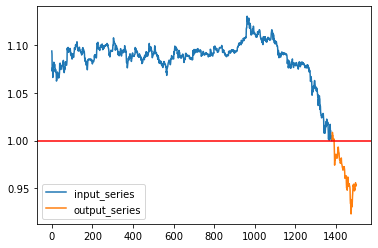

(1380,)


In [8]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()
print(train_x_array[idx,:,1].shape)

In [9]:
# Parameter search

# https://www.youtube.com/watch?v=rdR2fNDq6v0&t=690s 참조
import itertools
print('Examples of parameter combinations for Arima')
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
idx = 1012

aic = []
for i in pdq:
    model = ARIMA(train_x_array[idx,:,1], order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
    
# ARIMA p,d,q의 값중 p와 d가 1 이상이면 대체적으로 낮은 AIC값을 가짐
# 특히 p, q가 1일 때 대체적으로 낮은 AIC값을 가지므로 p,q 값을 1로 설정 d = 0

Examples of parameter combinations for Arima
ARIMA: (0, 0, 0) >> AIC : -6960.45
ARIMA: (0, 0, 1) >> AIC : -8647.94
ARIMA: (0, 0, 2) >> AIC : -9822.65
ARIMA: (0, 1, 0) >> AIC : -12954.01
ARIMA: (0, 1, 1) >> AIC : -12956.0
ARIMA: (0, 1, 2) >> AIC : -12954.14
ARIMA: (1, 0, 0) >> AIC : -12954.63
ARIMA: (1, 0, 1) >> AIC : -12947.82
ARIMA: (1, 0, 2) >> AIC : -12954.5
ARIMA: (1, 1, 0) >> AIC : -12956.22
ARIMA: (1, 1, 1) >> AIC : -12954.15
ARIMA: (1, 1, 2) >> AIC : -12951.94
ARIMA: (2, 0, 0) >> AIC : -12835.47
ARIMA: (2, 0, 1) >> AIC : -12949.05
ARIMA: (2, 0, 2) >> AIC : -12949.5
ARIMA: (2, 1, 0) >> AIC : -12954.19
ARIMA: (2, 1, 1) >> AIC : -12951.52
ARIMA: (2, 1, 2) >> AIC : -12948.32


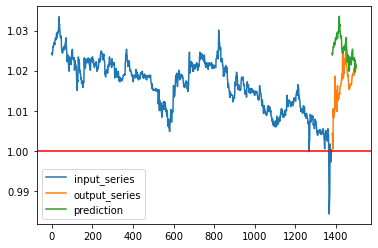

In [10]:
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_series를 추론
idx = 1121
series_x = train_x_array[idx,:,1]
series_y = train_y_array[idx,:,1]

model = ARIMA(series_x, order=(0,1,1))
fit = model.fit()
preds = fit.predict(1,120, typ = 'levels')

plot_series(series_x, series_y)
plt.plot(np.arange(len(series_x), len(series_x)+len(series_y)), preds, label = 'prediction')
plt.legend()
plt.show()
# arima 모델 적용시 예측값이 train data 초기값에 큰 영향을 받아 다소 동떨어지게 예측됨

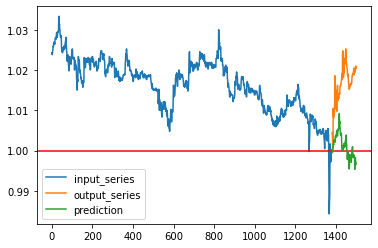

In [11]:
idx = 1121
series_x = train_x_array[idx,:,1]
series_y = train_y_array[idx,:,1]

model = ARIMA(series_x, order=(0,1,1))
fit = model.fit()
preds = fit.predict(1,120, typ = 'levels')
comp = preds[0] - 1 # series_x 마지막 open 값은 항상 1
pred = [i - comp for i in preds]

plot_series(series_x, series_y)
plt.plot(np.arange(len(series_x), len(series_x)+len(series_y)), pred, label = 'prediction')
plt.legend()
plt.show()

# train data의 끝값과 예측값의 첫값을 일치시킴

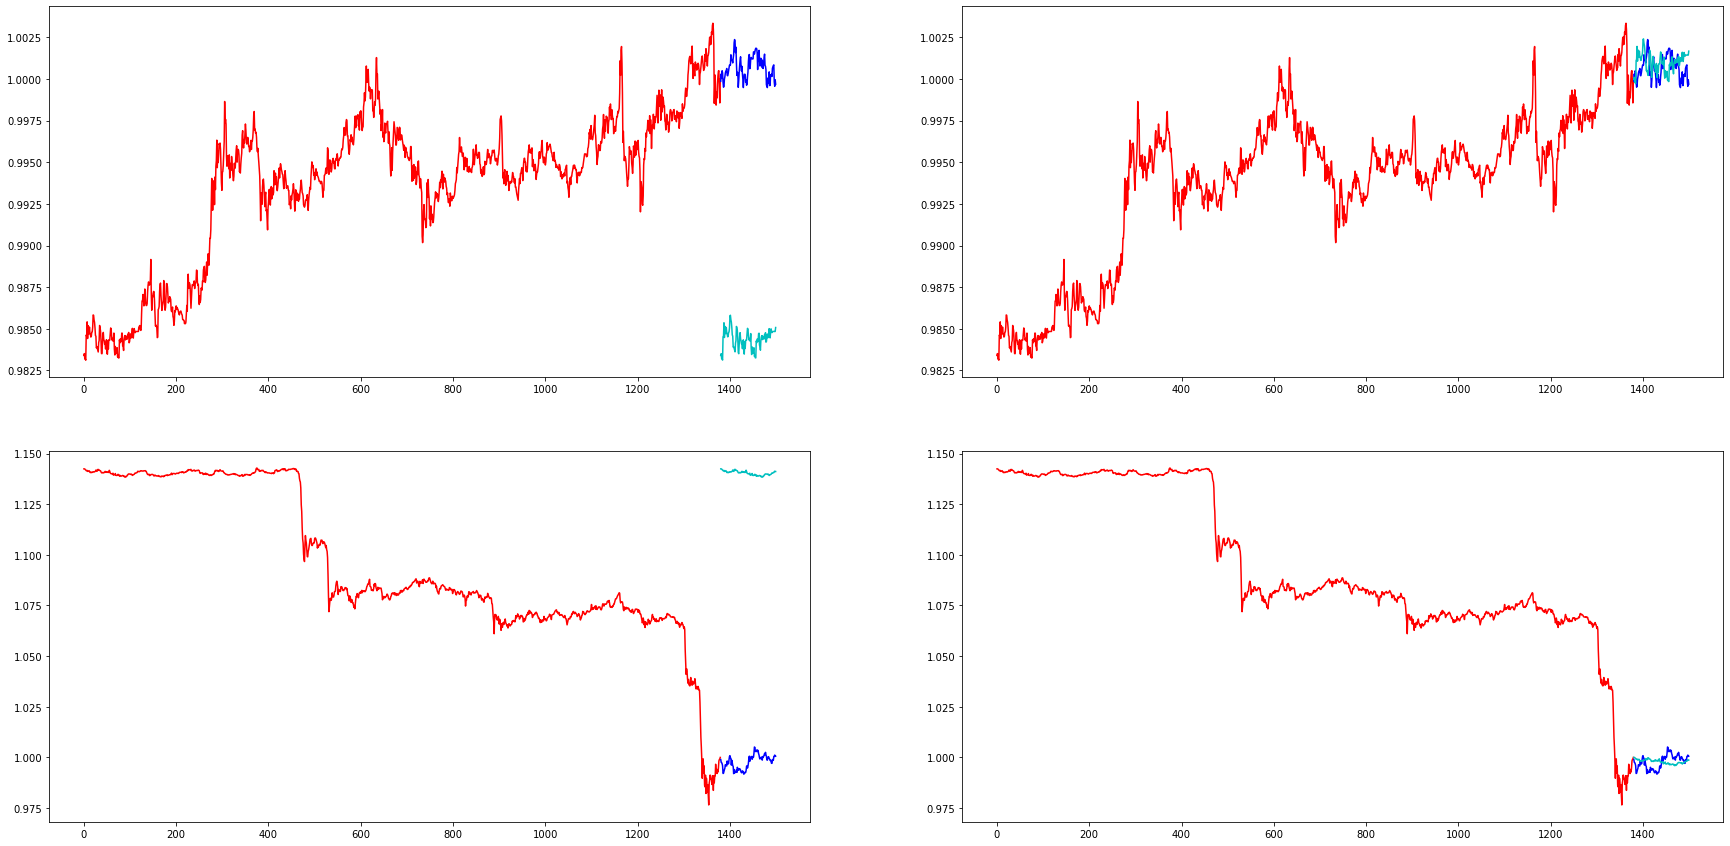

In [12]:
fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

idx = 1122
series_x = train_x_array[idx,:,1]
series_y = train_y_array[idx,:,1]

model = ARIMA(series_x, order=(0,1,1))
fit = model.fit()

# arima 모델 적용시 예측값이 train data 초기값에 큰 영향을 받아 
preds = fit.predict(1,120, typ = 'levels')
comp = preds[0] - 1 
pred = [i - comp for i in preds]


#plot_series(series_x, series_y)
ax1.plot(np.arange(len(series_x)), series_x, 'r')
ax1.plot(np.arange(len(series_x), len(series_x)+len(series_y)), series_y, 'b')
ax1.plot(np.arange(len(series_x), len(series_x)+len(series_y)), preds, 'c', label = 'prediction')

ax2.plot(np.arange(len(series_x)), series_x, 'r')
ax2.plot(np.arange(len(series_x), len(series_x)+len(series_y)), series_y, 'b')
ax2.plot(np.arange(len(series_x), len(series_x)+len(series_y)), pred, 'c', label = 'prediction')


idx = 255
series_x = train_x_array[idx,:,1]
series_y = train_y_array[idx,:,1]

model = ARIMA(series_x, order=(0,1,1))
fit = model.fit()

preds = fit.predict(1,120, typ = 'levels')
comp = preds[0] - 1 
pred = [i - comp for i in preds]

#plot_series(series_x, series_y)
ax3.plot(np.arange(len(series_x)), series_x, 'r')
ax3.plot(np.arange(len(series_x), len(series_x)+len(series_y)), series_y, 'b')
ax3.plot(np.arange(len(series_x), len(series_x)+len(series_y)), preds, 'c', label = 'prediction')

ax4.plot(np.arange(len(series_x)), series_x, 'r')
ax4.plot(np.arange(len(series_x), len(series_x)+len(series_y)), series_y, 'b')
ax4.plot(np.arange(len(series_x), len(series_x)+len(series_y)), pred, 'c', label = 'prediction')



plt.show()


In [13]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

In [14]:
for idx in tqdm(range(valid_x_array.shape[0])):
    x_series = valid_x_array[idx,:,1]

    model = ARIMA(x_series, order = (0,1,1))
    fit = model.fit()
    preds = fit.predict(1,120, typ = 'levels')
    comp = preds[0] - 1
    pred = [i-comp for i in preds]
    valid_pred_array[idx,:] = pred
        

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s]


In [15]:
def array_to_submission(x_array, pred_array):
    '''
    입력 x_array와 출력 pred_array를 통해서
    buy_quantity와 sell_time을 결정
    '''
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                             columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # n% 이상 상승한다고 예측한 sample에 대해서만 100%매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.02) * 1
    # 모델이 예측값 중 최대값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission

In [16]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [17]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,0,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
295,295,0,35
296,296,0,1
297,297,0,19
298,298,0,25


In [18]:
# 전체 300가지 sample에 대해
# 38가지 case에서 2% 이상 상승한다고 추론함
valid_submission.buy_quantity.value_counts()

0    261
1     39
Name: buy_quantity, dtype: int64

In [19]:
def df2d_to_answer(df_2d):
    '''
    valid_y_df로부터 open 가격정보가 포함된
    [샘플수, 120분] 크기의 2차원 array를 반환하는 함수
    '''
    
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    '''
    2차원 데이터프레임에서 open시점 데이터만 추출하여 array로 복원
    sample_id 정보를 index에 저장
    '''
    
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]
    
    # 초기 투자비용은 10000달러
    total_money = 10000 
    total_money_list = []

    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time = submission.loc[row_idx, 'sell_time']
        buy_price = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity']*total_money
        residual = total_money - buy_quantity
        ratio = sell_price / buy_price
        total_money = buy_quantity * ratio * 0.9995 * 0.9995 + residual
        total_money_list.append(total_money)

        
    return total_money, total_money_list, time
    

In [20]:
total_money, total_money_list, time = COIN(valid_y_df, valid_submission)

In [21]:
# 투자 후 금액
print(total_money)

10813.17716075343


In [22]:
# p,d,q : 1,0,1
# 44개 : 10730
# 43개 : 10725
# 42개 : 10711
# 41개 : 10720
# 40개 : 10761.963233
# 39개 : 10813.177
# 38개 : 10797.768
# 37개 : 10744.743
# 36개 : 10734
# 35개 : 10593.819

In [23]:
# p,d,q : 1,1,0
# 44개 : 10727.366
# 43개 : 10720.8
# 41개 : 10716.4
# 42개 : 10730.6
# 40개 : 10757.5
# 39개 : 10808.7
# 38개 : 10793.3
# 37개 : 10740.3
# 36개 : 10730.477

In [24]:
# p,d,q : 0,1,1
# 39개 : 10813.177
# 101과 값이 동일함

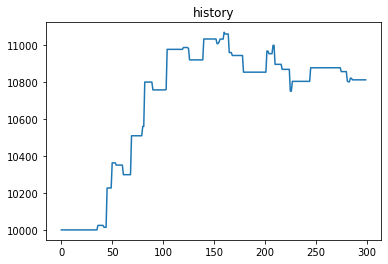

In [25]:
# 투자 히스토리
plt.plot(total_money_list)
plt.title('history')
plt.show()
#display(valid_submission[valid_submission.buy_quantity == 1])

In [26]:
test_pred_array = np.zeros([test_x_array.shape[0], 120])

for idx in tqdm(range(test_x_array.shape[0])):
    x_series = test_x_array[idx,:,1]
    
    model = ARIMA(x_series, order = (1,1,2))
    fit = model.fit()
    preds = fit.predict(1,120, typ = 'levels')
    comp = preds[0] - 1
    pred = [i-comp for i in preds]
    test_pred_array[idx,:] = pred


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [02:21<00:00,  3.74it/s]


In [27]:
submission = array_to_submission(test_x_array, test_pred_array)
submission.to_csv('submission.csv', index = False)


In [32]:
df1 = pd.read_csv("submission.csv")
df1

,sample_id,buy_quantity,sell_time
0,0,0,7
1,1,0,17
2,2,0,119
3,3,0,50
4,4,0,119
...,...,...,...
524,524,0,8
525,525,0,119
526,526,0,48
527,527,0,5


In [33]:
submission[submission.buy_quantity == 1]

len(submission[submission.buy_quantity == 1])

164